<a href="https://colab.research.google.com/github/shahd1995913/Tahalf-Mechine-Learning-DS3/blob/main/Exercise/Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Naive Bayes 👨🏻‍💻**

### From Scratch Implementation 🤔
---

In [ ]:
from __future__ import print_function, division
import numpy as np
import math
import progressbar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np


bar_widgets = [
    'Training: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),
    ' ', progressbar.ETA()
]


def standardize(X):
    """ Standardize the dataset X """
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_std

def normalize(X, axis=-1, order=2):
    """ Normalize the dataset X """
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

def train_test_split(X, y, test_size=0.5, shuffle=True, seed=None):
    """ Split the data into train and test sets """
    if shuffle:
        X, y = shuffle_data(X, y, seed)
    # Split the training data from test data in the ratio specified in
    # test_size
    split_i = len(y) - int(len(y) // (1 / test_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test


def shuffle_data(X, y, seed=None):
    """ Random shuffle of the samples in X and y """
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]

def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy

def calculate_covariance_matrix(X, Y=None):
    """ Calculate the covariance matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)
 

def calculate_correlation_matrix(X, Y=None):
    """ Calculate the correlation matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance = (1 / n_samples) * (X - X.mean(0)).T.dot(Y - Y.mean(0))
    std_dev_X = np.expand_dims(calculate_std_dev(X), 1)
    std_dev_y = np.expand_dims(calculate_std_dev(Y), 1)
    correlation_matrix = np.divide(covariance, std_dev_X.dot(std_dev_y.T))

    return np.array(correlation_matrix, dtype=float)

class Plot():
    def __init__(self): 
        self.cmap = plt.get_cmap('viridis')

    def _transform(self, X, dim):
        covariance = calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Sort eigenvalues and eigenvector by largest eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed


    def plot_regression(self, lines, title, axis_labels=None, mse=None, scatter=None, legend={"type": "lines", "loc": "lower right"}):
        
        if scatter:
            scatter_plots = scatter_labels = []
            for s in scatter:
                scatter_plots += [plt.scatter(s["x"], s["y"], color=s["color"], s=s["size"])]
                scatter_labels += [s["label"]]
            scatter_plots = tuple(scatter_plots)
            scatter_labels = tuple(scatter_labels)

        for l in lines:
            li = plt.plot(l["x"], l["y"], color=s["color"], linewidth=l["width"], label=l["label"])

        if mse:
            plt.suptitle(title)
            plt.title("MSE: %.2f" % mse, fontsize=10)
        else:
            plt.title(title)

        if axis_labels:
            plt.xlabel(axis_labels["x"])
            plt.ylabel(axis_labels["y"])

        if legend["type"] == "lines":
            plt.legend(loc="lower_left")
        elif legend["type"] == "scatter" and scatter:
            plt.legend(scatter_plots, scatter_labels, loc=legend["loc"])

        plt.show()



    # Plot the dataset X and the corresponding labels y in 2D using PCA.
    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        # Plot the different class distributions
        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        # Plot legend
        if not legend_labels is None: 
            plt.legend(class_distr, legend_labels, loc=1)

        # Plot title
        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        # Axis labels
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')

        plt.show()

    # Plot the dataset X and the corresponding labels y in 3D using PCA.
    def plot_in_3d(self, X, y=None):
        X_transformed = self._transform(X, dim=3)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        x3 = X_transformed[:, 2]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x1, x2, x3, c=y)
        plt.show()



class Sigmoid():
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))

    def gradient(self, x):
        return self.__call__(x) * (1 - self.__call__(x))

def make_diagonal(x):
    """ Converts a vector into an diagonal matrix """
    m = np.zeros((len(x), len(x)))
    for i in range(len(m[0])):
        m[i, i] = x[i]
    return m




In [ ]:
from __future__ import division, print_function
import numpy as np
import math

class NaiveBayes():
    """The Gaussian Naive Bayes classifier. """
    def fit(self, X, y):
        self.X, self.y = X, y
        self.classes = np.unique(y)
        self.parameters = []
        # Calculate the mean and variance of each feature for each class
        for i, c in enumerate(self.classes):
            # Only select the rows where the label equals the given class
            X_where_c = X[np.where(y == c)]
            self.parameters.append([])
            # Add the mean and variance for each feature (column)
            for col in X_where_c.T:
                parameters = {"mean": col.mean(), "var": col.var()}
                self.parameters[i].append(parameters)

    def _calculate_likelihood(self, mean, var, x):
        """ Gaussian likelihood of the data x given mean and var """
        eps = 1e-4 # Added in denominator to prevent division by zero
        coeff = 1.0 / math.sqrt(2.0 * math.pi * var + eps)
        exponent = math.exp(-(math.pow(x - mean, 2) / (2 * var + eps)))
        return coeff * exponent

    def _calculate_prior(self, c):
        """ Calculate the prior of class c
        (samples where class == c / total number of samples)"""
        frequency = np.mean(self.y == c)
        return frequency

    def _classify(self, sample):
        """ Classification using Bayes Rule P(Y|X) = P(X|Y)*P(Y)/P(X),
            or Posterior = Likelihood * Prior / Scaling Factor
        P(Y|X) - The posterior is the probability that sample x is of class y given the
                 feature values of x being distributed according to distribution of y and the prior.
        P(X|Y) - Likelihood of data X given class distribution Y.
                 Gaussian distribution (given by _calculate_likelihood)
        P(Y)   - Prior (given by _calculate_prior)
        P(X)   - Scales the posterior to make it a proper probability distribution.
                 This term is ignored in this implementation since it doesn't affect
                 which class distribution the sample is most likely to belong to.
        Classifies the sample as the class that results in the largest P(Y|X) (posterior)
        """
        posteriors = []
        # Go through list of classes
        for i, c in enumerate(self.classes):
            # Initialize posterior as prior
            posterior = self._calculate_prior(c)
            # Naive assumption (independence):
            # P(x1,x2,x3|Y) = P(x1|Y)*P(x2|Y)*P(x3|Y)
            # Posterior is product of prior and likelihoods (ignoring scaling factor)
            for feature_value, params in zip(sample, self.parameters[i]):
                # Likelihood of feature value given distribution of feature values given y
                likelihood = self._calculate_likelihood(params["mean"], params["var"], feature_value)
                posterior *= likelihood
            posteriors.append(posterior)
        # Return the class with the largest posterior probability
        return self.classes[np.argmax(posteriors)]

    def predict(self, X):
        """ Predict the class labels of the samples in X """
        y_pred = [self._classify(sample) for sample in X]
        return y_pred

Accuracy: 0.9136490250696379


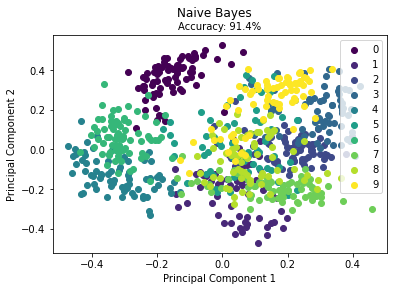

In [ ]:
from __future__ import division, print_function
from sklearn import datasets
import numpy as np

def main():
    data = datasets.load_digits()
    X = normalize(data.data)
    y = data.target

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    clf = NaiveBayes()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    print ("Accuracy:", accuracy)

    # Reduce dimension to two using PCA and plot the results
    Plot().plot_in_2d(X_test, y_pred, title="Naive Bayes", accuracy=accuracy, legend_labels=data.target_names)

if __name__ == "__main__":
    main()